# SPEED workflow (stage 1/2): Training on the atlas-level single-cell data.

Dataset: The atlas-level single-cell data ([here](https://doi.org/10.5281/zenodo.14948507))

**Note**:  incorporating a single-cell reference substantially improved performance over using no reference, whereas supplementing with a large-scale atlas-level reference yielded only modest additional gains beyond the best-performing individual single-cell dataset.

In [1]:
import torch
print("Whether GPU is detected:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

Whether GPU is detected: True
CUDA version: 11.7


In [2]:
import os
import sys

In [3]:
import SPEED
import scanpy as sc

## load the data

Load the single-cell data. 

In [4]:
adata = sc.read('singlecell/scAtlas_ATAC_ME_process.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 266242 × 284757
    obs: 'Sample', 'Clusters'

## Initialize the SPEED model

### Initialize the model with single-cell data. 

`is_spatial` is set to `False` during the first stage of training on single-cell data. `is_spatial = False` indicates stage 1 training, while `is_spatial = True` indicates stage 2 training. 

When `is_spatial = False`, the parameters for processing spatial data (`image`, `k_degree`, `adata_sc`, `peak_name`) will be ignored.

In [6]:
speed = SPEED.SPEED(adata, is_spatial=False)

matrix ready...
use 0-1 matrix...
cell_features ready...
peak features ready...


### Spliting training and validation sets.

`num_workers` is the number of subprocesses for data loading (default = 4).

`data_type` sets the input data format used by SPEED. SPEED will handle this format internally, so no external action is required from the user. For lower GPU memory and faster training, it is recommended to set `dense = False` (default) when training on GPU, and `dense = True` when training on CPU.

`batch_size_cell` and `batch_size_peak` are the batch sizes at the cell-level and peak-level. SPEED will choose automatically according to dataset size, but if the batch size is too large for your GPU, you can reduce it manually.

`split_ratio` sets the proportion of the validation set at both the cell level and peak level. (default = [1/6, 1/6])

In [7]:
speed.setup_data(num_workers=4, data_type='sparse')

batch_size_cell = 32768, batch_size_peak = 32768
split ready...
labels ready...
dataset ready...


### Build the neural network model for SPEED.

`emb_features` is the number of embedding features (default = 32).

`dropout_p` is the dropout probability of the model. For single-cell data training, `dropout_p` is recommended to 0.2.

`nn_width_coef` is the coefficient for the hidden layer width. The final network width equals the default width multiplied by `nn_width_coef`. Default is 1. When the number of cells in the dataset exceeds 1 million, it can be set to 0.1 to reduce memory and GPU usage.

In [8]:
speed.build_model(emb_features=32,dropout_p=0.2,nn_width_coef=1)

## Train the SPEED model

`lr` is the learning rate. `device` specifies whether to train with GPU or CPU.

`epoch_num` is the maximum number of training epochs (default = 500). If no improvement is observed on the validation set within `epo_max` epochs, training is considered converged and will stop. When training on large-scale single-cell atlas-level data, it is recommended to use `epo_max = 10`. When training on spatial epigenomic data, it is recommended to use `epo_max = 30` (default).

In [ ]:
speed.train(lr=1e-5, device='cuda', epoch_num=500, epo_max=10)

## Get the results

Use `SPEED.SPEED.get_embedding` to get the low-dimensional embedding.

The spot/cell embeddings will be stored in `adata.obsm['X_SPEED']`. The peak embeddings will be stored in `adata.varm['peak_SPEED']`

In [ ]:
adata = speed.get_embedding(adata)

In [11]:
sc.pp.neighbors(adata, use_rep='X_SPEED', random_state=1)
sc.tl.umap(adata)
sc.tl.leiden(adata, random_state=1, key_added="leiden_spot",resolution=0.5)

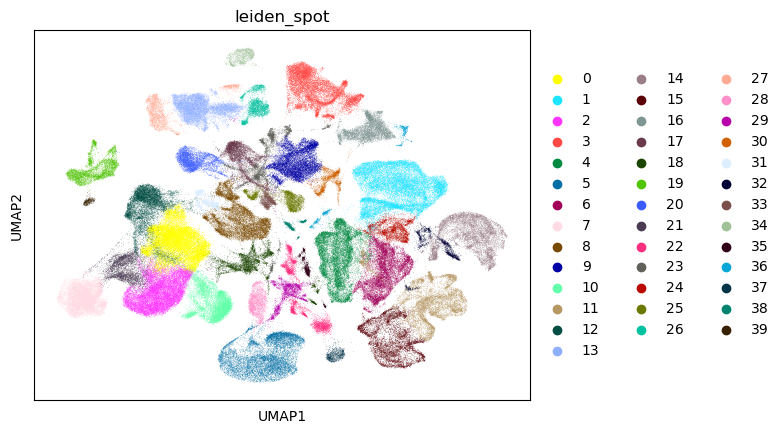

In [12]:
sc.pl.umap(adata,color='leiden_spot')

In [14]:
adata.write('scME_out/adata_speed.h5ad')